## Backtesting Portfolio Strategies Part 1

In this notebook I want to define one or two functions to backstest portfolio strategies and put them in a file called `Utils.py` from which I can call them directly and see the results.

Once decided a set of assets to be included in a portfolio, I collect their historical prices using the fucntion `prices` and structure them in a DataFrame.

Then I define my strategy: essentially the initial weights I want to give to each asset in my portfolio. I might also want to rebalance each asset's weight with a certain frequency (e.g. every 12 months).

**Backtesting** means to evaluate the strategy performance based on what happened in the past from the asset historical prices.

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('ggplot')

#### 1. Backtesting a simple strategy

I decide the assets to include in my portfolio and the weights I want to assign to each asset.
For example, I take 4 assets, each weighting 25%. The *weight* is the proportion of my initial capital allocated on each asset. 

I do nothing for the rest of the time: the weight (proportion of total portfolio value) of better performing assets will increase over time compared to their initial weight. Consequently, weights of less performing assets will decrease.

In [3]:
# asset's tickers
tickers = ['CSSPX','EM710','ITPS','PHAU']
# inital weights assigned per ticker
initial_weights = [1/len(tickers) for tick in tickers]
print(initial_weights)

[0.25, 0.25, 0.25, 0.25]


In [4]:
# importing necessary functions from Utils
from Utils import prices, portfolio_prices

In [5]:
# taking single asset prices
data = []
for tick in tickers:
    data.append(prices(ticker=tick))

# structuring asset prices in a DataFrame
pf_prices = portfolio_prices(data)

pf_prices.head(3)

,CSSPX,EM710,ITPS,PHAU
Date,,,,
2010-05-19,72.849998,122.160004,133.350006,95.830002
2010-05-20,72.849998,122.199997,132.089996,95.070000
2010-05-21,72.849998,122.349998,130.199997,93.260002


Suppose I have only the daily returns of each asset. I can calculate the cumulative normalized value like that:
$$V_{t} = V_{0}(1+R_{1})(1+R_{2})\cdot \cdot \cdot   (1+R_{t})$$
In other words I take the initial value $V_{0}$ and multiply it by the cumulative daily growth of the asset.

Let's show it using the first few days of `PHAU` prices in the `pf_prices` DataFrame.
I want to check whether I obtain the same price of `PHAU` on *May 31, 2010* by using this formula.

In [6]:
day_test = '2010-05-31'
print('PHAU price on', day_test+':')
print(pf_prices.loc[day_test,'PHAU'])

PHAU price on 2010-05-31:
97.94000244140625


In [7]:
phau = pf_prices.loc[:day_test,'PHAU'] # taking PHAU's prices up to day_test
phau = phau.pct_change().fillna(0) # calculating daily returns
phau = phau + 1 # calculating daily growth
phau = phau.cumprod() # calculating daily cumulative growth
phau.tail(1) # cumulative growth on day_test

Date
2010-05-31    1.022018
Name: PHAU, dtype: float64

If this formula works I should obatain PHAU price on May 31 by multiplying the cumulative growth at May 31 by the price of PHAU at the beginning:

In [8]:
beginning_price = pf_prices.loc[:day_test,'PHAU'].iloc[0]
print('PHAU calculated price on', day_test+':')
print(beginning_price*phau.iloc[-1])
print('Are PHAU May 31 true and calculated prices the same?')
print((pf_prices.loc[day_test,'PHAU']) == (beginning_price*phau.iloc[-1]))

PHAU calculated price on 2010-05-31:
97.94000244140625
Are PHAU May 31 true and calculated prices the same?
True


Now we can apply it to the whole portfolio.

<Axes: title={'center': 'Asset Normalized Values Over Time'}, xlabel='Date', ylabel='Normalized Values'>

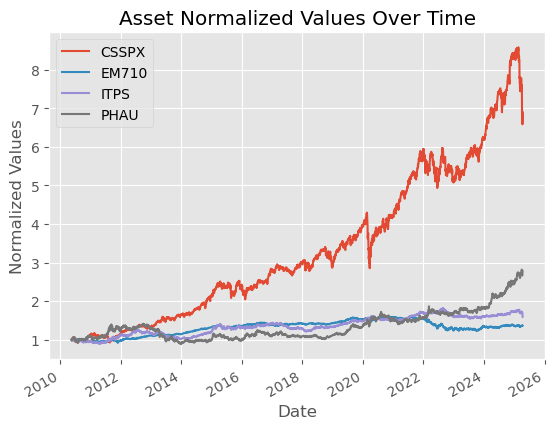

In [9]:
daily_returns = pf_prices.pct_change().fillna(0)
daily_growth = daily_returns + 1
cumulative_growth = daily_growth.cumprod()
cumulative_growth.plot(title='Asset Normalized Values Over Time',
                                         ylabel='Normalized Values')

To calculate Porfolio Normalized Values Over Time I just need to multiply each asset cumulative growth by their initial weights in portfolio.

In other words, I assume to invest 1 Euro at the beginnig and put 0.25 Euros on each asset, because I decided to give weight 0.25 to each asset.

1 Euro invested in this strategy would be worth 3.12 Euros today


<Axes: title={'center': 'Portfolio Normalized Value Over Time'}, xlabel='Date', ylabel='Normalized Value'>

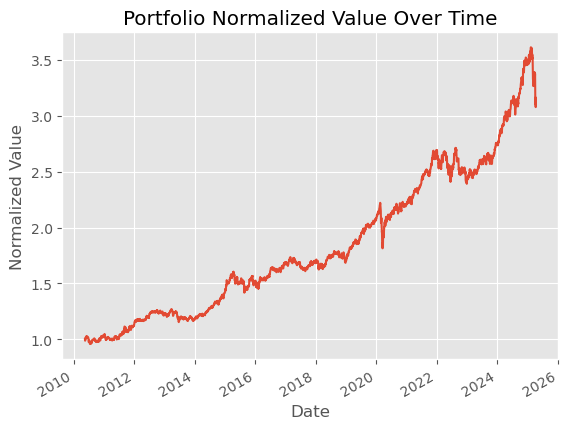

In [10]:
pf_norm_val = (cumulative_growth*initial_weights).sum(axis=1)
print('1 Euro invested in this strategy would be worth', pf_norm_val.iloc[-1].round(2), 'Euros today')
pf_norm_val.plot(title='Portfolio Normalized Value Over Time', ylabel='Normalized Value')

I can write a function backtesting this strategy for any number of assets in a portfolio given any intial weights.

In [11]:
def backtest_portfolio(ticker_prices, initial_weights):
    """Backtests a strategy over time calculating the daily Asset and Portfolio Normalized Values
    
    Args:
        ticker_prices (pd.DataFrame): DataFrame with asset daily prices
        initial_weights (list or np.array): Weights of each asset
    
    Returns:
        pd.DataFrame: Daily Normalized Values of assets and whole portfolio, indexed by date.
        """
    daily_returns = ticker_prices.pct_change().fillna(0)
    daily_growth = daily_returns + 1
    cumulative_growth = daily_growth.cumprod()
    cumulative_growth *= initial_weights
    cumulative_growth['Portfolio'] = cumulative_growth.sum(axis=1)
    return cumulative_growth

In [12]:
pf_norm_val = backtest_portfolio(ticker_prices=pf_prices, initial_weights=initial_weights)
pf_norm_val.tail()

,CSSPX,EM710,ITPS,PHAU,Portfolio
Date,,,,,
2025-04-07,1.672478,0.339514,0.424053,0.665136,3.101181
2025-04-08,1.728861,0.339411,0.424691,0.670928,3.163890
2025-04-09,1.646294,0.339677,0.412561,0.678545,3.077078
2025-04-10,1.712354,0.340864,0.411024,0.688459,3.152701
2025-04-11,1.691215,0.341274,0.397919,0.693572,3.123979


In [13]:
print('Weights of each asset today:')
(pf_norm_val[tickers].iloc[-1]/pf_norm_val.Portfolio.iloc[-1]).round(2)

Weights of each asset today:


CSSPX    0.54
EM710    0.11
ITPS     0.13
PHAU     0.22
Name: 2025-04-11 00:00:00, dtype: float64

Here we clearly see how the assets that performed better over time have significantly increased their weight on the total porftolio value. Assets with poorer performance decreased their weights. 

#### 2. Backtesting a more complex strategy

I decide the assets to include in my portfolio and the weights I want to assign to each asset.
For example, I take 4 assets, each weighting 25%. The *weight* is the proportion of my initial capital allocated on each asset. 

I want to rebalance asset weights every 12 months. This means that I report all weights to the initially assigned weight, by reducing weights increased compared to their initial weight (higher performing assets) and reporting to the initial weights assets with lower performance.

In [14]:
# asset's tickers
tickers = ['CSSPX','EM710','ITPS','PHAU']
# inital weights assigned per ticker
initial_weights = [1/len(tickers) for tick in tickers]

# taking single asset prices
data = []
for tick in tickers:
    data.append(prices(ticker=tick))

# structuring asset prices in a DataFrame
pf_prices = portfolio_prices(data)

pf_prices.head(3)

,CSSPX,EM710,ITPS,PHAU
Date,,,,
2010-05-19,72.849998,122.160004,133.350006,95.830002
2010-05-20,72.849998,122.199997,132.089996,95.070000
2010-05-21,72.849998,122.349998,130.199997,93.260002


We simulate a portfolio strategy where we rebalance periodically (e.g. annually), allocating funds according to fixed weights and letting them grow between rebalances. The value of the portfolio compounds over time.

1. **Normalize asset prices.**
Each asset's price is scaled relative to its initial price, so all start at 1: $$P_{norm} = \frac{P_{t}}{P_{t=0}}$$
 
2. **Create rebalance date indices.**
Based on a rebalancing frequency (e.g. 252 trading days), we generate an array of row indices in the price data to use as rebalance points.

3. **Initialize portfolio tracking.**
We create an empty pd.Series to store the evolving portfolio value over time. We also initialize the portfolio's starting value (e.g. 1.0).

In [15]:
# Step 1: Normalize prices
pf_norm_val = pf_prices / pf_prices.iloc[0]

# Step 2: Create array of rebalancing indices (yearly)
idx_rebalance = np.arange(0, len(pf_norm_val), 252)

# Step 3: Initialize asset and portfolio values
asset_vals = pd.DataFrame(index=pf_norm_val.index, columns=pf_norm_val.columns, dtype='float64')
portfolio_vals = pd.Series(index=pf_norm_val.index, dtype='float64')
weights = np.array(initial_weights)

# Step 4: Starting portfolio value
portfolio_value = 1.0  # could be 100 or 1M, but we'll use 1.0 for normalized returns

4. Then we **loop over rebalance periods**
For each pair of rebalance dates:

    - define the time interval (chunk) between two rebalancing dates.

    - subset the normalized price data for this interval.

5. Within each **rebalance chunk**:

    - take the normalized prices at the beginning of the chunk: `start_prices`.

    - allocate the current portfolio value across assets using predefined `weights`.

    - compute the number of units (or shares) held of each asset: `units_held = money_ allocation/start_ prices`

    - calculate the daily portfolio value during this period using the dot product between the normalized prices and the `units_held`: this gives us a time series of the portfolio’s value during that chunk. 

    - insert it into our full portfolio series.

    - Finally, update the portfolio value using the last value of this chunk and proceed to the next period.

In [16]:
# Step 5: Rebalance loop
for i in range(len(idx_rebalance)):
    start_idx = idx_rebalance[i]
    end_idx = idx_rebalance[i + 1] if i + 1 < len(idx_rebalance) else len(pf_norm_val)
    
    period_prices = pf_norm_val.iloc[start_idx:end_idx]
    start_prices = period_prices.iloc[0]
    
    # Allocate current portfolio value according to weights
    money_allocation = portfolio_value * weights
    units_held = money_allocation / start_prices
    
    # Evolve values for each asset and portfolio value during this period
    period_asset_vals = period_prices.multiply(units_held, axis=1)
    period_portfolio_vals = period_asset_vals.sum(axis=1)
    
    # Store into full series
    portfolio_vals.iloc[start_idx:end_idx] = period_portfolio_vals
    asset_vals.iloc[start_idx:end_idx] = period_asset_vals
    
    # Update portfolio value for next period (last value of this period)
    portfolio_value = period_portfolio_vals.iloc[-1]


In [17]:
# check that the Datframes have the same length as the prices Dataframe
len(portfolio_vals), len(asset_vals), len(pf_prices)

(3789, 3789, 3789)

<Axes: title={'center': 'Annually Rebalanced Portfolio Value'}, xlabel='Date'>

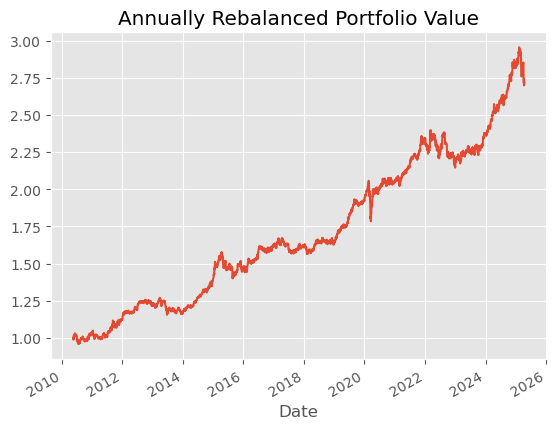

In [18]:
# Portfolio Plot
portfolio_vals.plot(title="Annually Rebalanced Portfolio Value")

**Note** in the graph below the effect of rebalaning that transfers money from better performing assets to poorer performing assets at each rebalance point. Therefore the increased value over time of poorer performing assets is not only due to their performance, but also to the money transferred on them at rebalance points.

<Axes: title={'center': 'Annually Rebalanced Asset Values'}, xlabel='Date'>

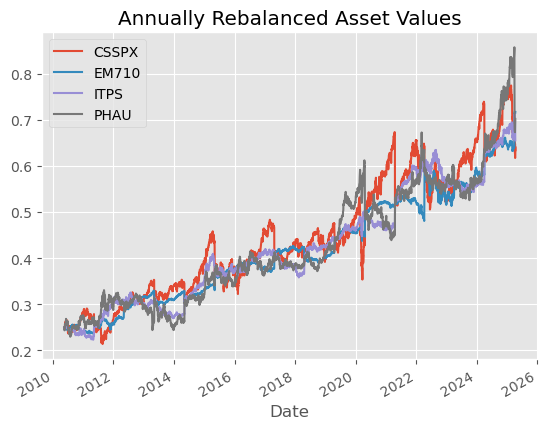

In [19]:
asset_vals.plot(title="Annually Rebalanced Asset Values")

Now I can generalize the function `backtest_portfolio` with optional periodic rebalancing for any number of assets in a portfolio given any intial `weights`. The argument `rebalance` ca be set to `True` for rebalancing or to `False` for *buy-and-hold* strategy.  The argument `rebalance_freq` is for deciding the rebalance frequency in number of trading days.

In [20]:
def backtest_portfolio(prices: pd.DataFrame,
                       weights: list,
                       rebalance: bool = False,
                       rebalance_freq: int = 252,
                       initial_value: float = 1.0) -> pd.DataFrame:
    """
    Backtest a portfolio with optional rebalancing, returning asset and portfolio normalized values.

    Parameters:
    - prices: DataFrame of asset prices (rows = dates, columns = tickers)
    - weights: List or array of asset weights (same order as columns)
    - rebalance: Whether to rebalance periodically (default = False)
    - rebalance_freq: Frequency of rebalancing in trading days (default = 252 = yearly)
    - initial_value: Initial portfolio value (default = 1.0)

    Returns:
    - DataFrame of normalized values per asset and total portfolio
    """
    
    # Step 1: Normalize prices
    norm_prices = prices / prices.iloc[0]
    weights = np.array(weights)

    # Step 2: Rebalance dates
    if rebalance:
        idx_rebalance = np.arange(0, len(norm_prices), rebalance_freq)
    else:
        idx_rebalance = [0]

    # Step 3: Prepare output DataFrame
    asset_vals = pd.DataFrame(index=norm_prices.index, columns=norm_prices.columns, dtype='float64')
    portfolio_vals = pd.Series(index=norm_prices.index, dtype='float64')

    portfolio_value = initial_value

    for i in range(len(idx_rebalance)):
        start_idx = idx_rebalance[i]
        end_idx = idx_rebalance[i + 1] if i + 1 < len(idx_rebalance) else len(norm_prices)

        period_prices = norm_prices.iloc[start_idx:end_idx]
        start_prices = period_prices.iloc[0]

        # Allocate value per asset
        money_allocation = portfolio_value * weights
        units_held = money_allocation / start_prices

        # Calculate values for each asset and total portfolio
        period_asset_vals = period_prices.multiply(units_held, axis=1)
        period_portfolio_vals = period_asset_vals.sum(axis=1)

        # Store results
        asset_vals.iloc[start_idx:end_idx] = period_asset_vals
        portfolio_vals.iloc[start_idx:end_idx] = period_portfolio_vals

        # Update portfolio value for next rebalance period
        portfolio_value = period_portfolio_vals.iloc[-1]

        if not rebalance:
            break

    # Combine into one DataFrame
    result = asset_vals.copy()
    result['Portfolio'] = portfolio_vals
    return result


<Axes: title={'center': 'Annually Rebalanced Portfolio Values'}, xlabel='Date'>

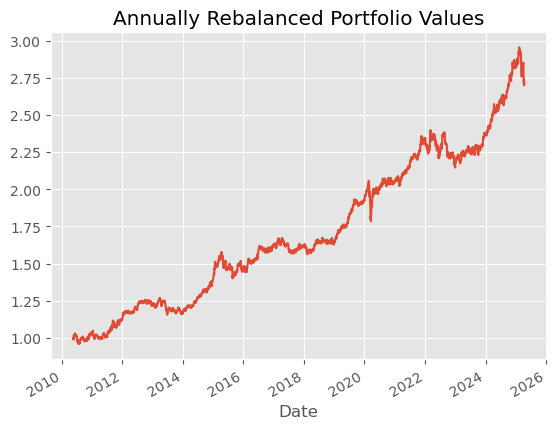

In [21]:
# testing the function with rebalance
df = backtest_portfolio(prices=pf_prices, weights=initial_weights, rebalance=True, rebalance_freq=252)
df.Portfolio.plot(title="Annually Rebalanced Portfolio Values")

<Axes: title={'center': 'Annually Rebalanced Asset Values'}, xlabel='Date'>

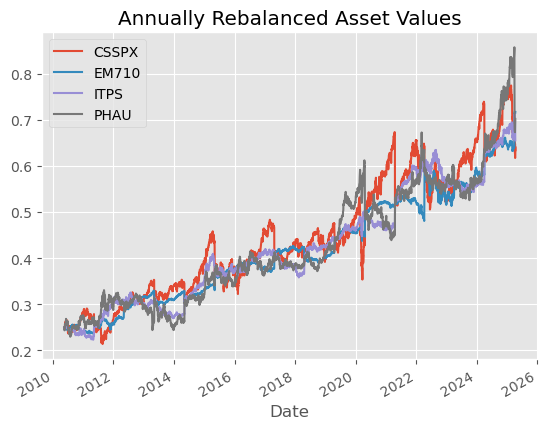

In [22]:
df[tickers].plot(title="Annually Rebalanced Asset Values")

<Axes: title={'center': 'Portfolio Values over time buy-and-hold strategy'}, xlabel='Date'>

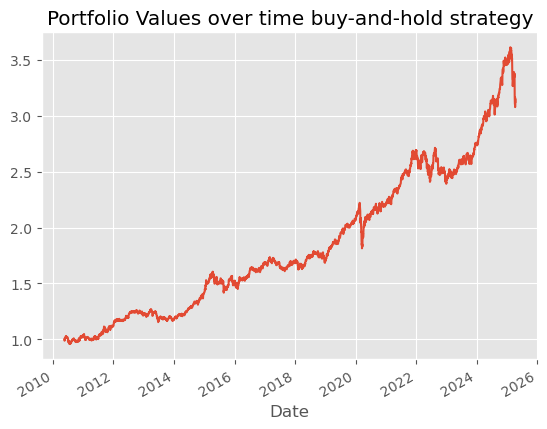

In [23]:
# testing the function with buy-and-hold strategy
df = backtest_portfolio(prices=pf_prices, weights=initial_weights, rebalance=False)
df.Portfolio.plot(title="Portfolio Values over time buy-and-hold strategy")

<Axes: title={'center': 'Asset Values over time buy-and-hold strategy'}, xlabel='Date'>

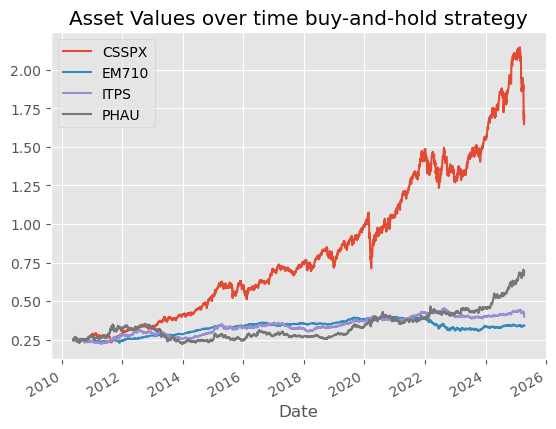

In [24]:
df[tickers].plot(title="Asset Values over time buy-and-hold strategy")

Remember that we started the portfolio at 1.0 in all strategies. This means that we assume to invest 1 Euro at the beginnig and allocate it on each asset based on the initial weights decided. Because we decided to give weight 0.25 to each asset, each asset value starts from 0.25.

### Summary

In this chapter we have addressed the problem of **backesting** portfolio strategies. We started from the historical price series of different assets in a portfolio and the weights to assign to each asset in the portfolio.

Then we determined the evolution over time of two strategies: *buy-and-hold* and *rebalancing asset weights* at a given frequency (e.g. every 12 months).

We defined the funtion `backtest_portfolio()` that returns a DataFrame of normalized values per asset and total portfolio. 

Now I want to move to calculating the performance of a portfolio strategy.